In [19]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

In [20]:
from src.helpers import get_dir

In [58]:
data_dir = '../data'
output_dir = '../outputs'
selected_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

In [22]:
df_train = pd.read_csv(f"{data_dir}/preprocessed/tabular_train.csv")
df_test = pd.read_csv(f"{data_dir}/preprocessed/tabular_test.csv")
df_all = pd.concat([df_train, df_test])

display(df_all.head())

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop
0,44,40,40,42,45,59,70,63,76,13,78,55,1374,1.0
1,44,40,40,42,45,59,70,62,76,13,78,55,1374,1.0
2,44,40,39,42,46,52,58,54,62,16,72,53,3293,1.0
3,44,41,39,43,48,58,65,61,71,16,78,61,3293,1.0
4,44,40,40,44,48,58,65,64,71,16,78,61,3293,1.0


## Data preprocessing

### Augmenting rows

In [23]:
def add_column_statistics(df, columns, by_column=None, add_std=False):
    df = df.copy()

    if by_column:
        for i in columns:
            df[f'{i}_min_by_fid'] = df.groupby(by_column)[i].transform('min')
            df[f'{i}_max_by_fid'] = df.groupby(by_column)[i].transform('max')
            df[f'{i}_avg_by_fid'] = df.groupby(by_column)[i].transform('mean')

            if add_std:
                df[f'{i}_std_by_fid'] = df.groupby(by_column)[i].transform('std')
    else:
        for i in columns:
            if add_std:
                df[f'{i}_std'] = df.filter(regex = f'^{i}').std(axis = 1)
                
            df[f'{i}_max'] = df.filter(regex = f'^{i}').max(axis = 1)
            df[f'{i}_min'] = df.filter(regex = f'^{i}').min(axis = 1)
            df[f'{i}_avg'] =df.filter(regex = f'^{i}').mean(axis = 1)

    return df
    

def add_column_mappings(df, columns, add_sqrt=False):
    df = df.copy()

    for i in columns:
        
        if add_sqrt:
            df[f'{i}_sqrt'] = np.sqrt(df[i].values)
            
        df[f'{i}_exp'] = np.exp(df[i].values)
        df[f'{i}_^2'] = df[i].values**2
    
    return df

### Add spetral indices

In [24]:
spectral_indices = [
    "NDVI",
    "GNDVI",
    # "EVI",
    "EVI2",
    # "AdvVI", # Advanced vegitation index
    "BSI",
    "SI",
    "NDWI",
    "NDMI",
    "NPCRI",
    "SAVI",
    "MSI",
    "GCI",
    "NBRI",
    "NDSI",
    "NDGI",
    "ARVI",
    "SIPI",
    
    # other from paper  https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full 
    # "AFRI1.6",
    # "AFRI2.1",
    #"ARI",
    # "ARVI_paper",
    # "ARVI2", # depends on a hyperparameter
    # "ATSAVI" # depends on a hyperparameter
    # "AshVI", # Ashburn vegetation index
    # "BNDVI",
    # "BRI",
    
    # "BWDRVI",
    # "MCARI1",
    # "MCARI2",
    # "CCCI",
    # "CRI550",
    # "CRI700",
    # "CVI",
    # "Datt1",
    # "Datt2",
    # "Datt3",
    # "DVI",
    # "NDI45"
]

def add_spectral_indices(df, phi=1, a=1.22, b=0.03, X=0.08):
    df = df.copy()
    
    df["NDVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"])
    df["GNDVI"] = (df["B08"] - df["B03"]) / (df["B08"] + df["B03"])
    # df["EVI"] = 2.5 * ((df["B08"] - df["B04"]) / ((df["B08"] + 6.0 * df["B04"] - 7.5 * df['B02']) + 1.0))
    df["EVI2"] = 2.4 * (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 1.0)
    # df["AdvVI"] = (df["B08"] * (1 - df["B04"]) * (df["B08"] - df["B04"]))**(1/3)
    df["BSI"] = ((df["B11"] + df["B04"]) - (df["B08"] + df["B02"])) / ((df["B11"] + df["B04"]) + (df["B08"] + df["B02"]))
    df["SI"] = ((1 - df["B02"]) * (1 - df["B03"]) * (1 - df["B04"]))
    df["NDWI"] = (df["B03"] - df["B08"]) / (df["B03"] + df["B08"])
    df["NDMI"] = (df["B08"] - df["B11"]) / (df["B08"] + df["B11"]) 
    df["NPCRI"] = (df["B04"] - df["B02"]) / (df["B04"] + df["B02"]) 
    df["SAVI"] = (df["B08"] - df["B04"]) / (df["B08"] + df["B04"] + 0.428) * (1.428)
    df["MSI"] = df["B11"] / df["B08"]
    df["GCI"] = (df["B09"] / df["B03"]) - 1
    df["NBRI"] = (df["B08"] - df["B12"]) / (df["B08"] + df["B12"])
    df["NDSI"] = (df["B03"] - df["B11"]) / (df["B03"] + df["B11"])
    df["NDGI"] = (df["B03"] - df["B04"]) / (df["B03"] + df["B04"]) 
    df["ARVI"] = (df["B08"] - (2 * df["B04"]) + df["B02"]) / (df["B08"] + (2 * df["B04"]) + df["B02"]) 
    df["SIPI"] = (df["B08"] - df["B02"]) / (df["B08"] - df["B04"])
    
    # other from paper  https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full 
    # df["AFRI1.6"] = (df["B8A"] - 0.66*df["B11"]) / (df["B8A"] + 0.66*df["B11"])
    # df["AFRI2.1"] = (df["B8A"] - 0.5*df["B12"]) / (df["B8A"] + 0.5*df["B12"])
    # df["ARI"] = ((1/df["B03"]) - (1/df["B05"]))
    # df["ARVI_paper"] = (df["B08"] - (df["B04"] - phi*(df["B02"] - df["B04"]))) / (df["B08"] + (df["B04"] - phi*(df["B02"] - df["B04"])))
    # df["ARVI2"] = -0.18 + 1.17 + ((df["B08"] - df["B04"]) / (df["B08"] + df["B04"]))
    # df["ATSAVI"] = a*(df["B08"] - a*df["B04"] - b) / (df["B08"] + df["B04"] - a*b + X*(1 + a**2))
    # df["AshVI"] = 2*df["B8A"] - df["B04"]
    # df["BNDVI"] = (df["B08"] - df["B02"]) / (df["B08"] + df["B02"])
    # df["BRI"] = ((1 / df["B03"]) - (1 / df["B05"])) / df["B06"]
    
    # df["BWDRVI"] = (0.1*df["B07"] - df["B02"])/(0.1*df["B07"] + df["B02"])
    
    # Chlorophyll absorption ratio index
    # df["MCARI"] = ((df["B05"] - df["B04"]) - 0.2*(df["B05"] - df["B03"])) * (df["B05"]/df["B04"])
    # df["MCARI1"] = 1.2 * (2.5 * df["B08"] - df["B04"]) - 1.3*(df["B08"] - df["B03"])
    # df["MCARI2"] = 1.5 * ((2.5 * (df["B08"] - df["B04"]) - 1.3*(df["B08"] - df["B03"])) / ((((2*df["B08"] + 1)**2 - (6*df["B08"] - 5*(df["B04"]**(1/2)))) ** (1/2))) - 0.5)
    
    # df["CCCI"] = ((df["B08"] - df["B05"]) / (df["B08"] + df["B05"])) / ((df["B08"] - df["B04"]) / (df["B08"] + df["B04"]))
    # df["CRI550"] = (1 / df["B02"]) - (1 / df["B03"])
    # df["CRI700"] = (1 / df["B02"]) - (1 / df["B05"])
    # df["CVI"] = (df["B08"] * df["B08"]) / (df["B03"])**2
    # df["Datt1"] = (df["B08"] - df["B05"]) / (df["B08"] + df["B04"])
    # df["Datt2"] = df["B04"] / (df["B03"] * df["B05"])
    # df["Datt3"] = df["B8A"] / (df["B03"] * df["B05"])
    # df["DVI"] = 2.4 * df["B08"] - df["B04"]
    # df["NDI45"] = (df["B05"] - df["B04"]) / (df["B05"] + df["B04"])
    
    return df

In [25]:
# spectral bands
df_all = add_column_statistics(df_all, selected_bands)
# df_all = add_column_mappings(df_all, selected_bands, add_sqrt=True)
df_all = add_column_statistics(df_all, selected_bands, "field_id")

# spectral indices
df_all = add_spectral_indices(df_all)
df_all = add_column_statistics(df_all, spectral_indices)
# df_all = add_column_mappings(df_all, spectral_indices)
df_all = add_column_statistics(df_all, spectral_indices, "field_id")

display(df_all.head())

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDSI_avg_by_fid,NDGI_min_by_fid,NDGI_max_by_fid,NDGI_avg_by_fid,ARVI_min_by_fid,ARVI_max_by_fid,ARVI_avg_by_fid,SIPI_min_by_fid,SIPI_max_by_fid,SIPI_avg_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,-0.317357,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093
1,44,40,40,42,45,59,70,62,76,13,...,-0.317357,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093
2,44,40,39,42,46,52,58,54,62,16,...,-0.312590,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843
3,44,41,39,43,48,58,65,61,71,16,...,-0.312590,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843
4,44,40,40,44,48,58,65,64,71,16,...,-0.312590,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843


In [26]:
df_all = df_all.join(df_all.groupby("field_id").size().rename(f'num_pixels_by_fid'), on='field_id')

df_all.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDGI_min_by_fid,NDGI_max_by_fid,NDGI_avg_by_fid,ARVI_min_by_fid,ARVI_max_by_fid,ARVI_avg_by_fid,SIPI_min_by_fid,SIPI_max_by_fid,SIPI_avg_by_fid,num_pixels_by_fid
0,44,40,40,42,45,59,70,63,76,13,...,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093,36
1,44,40,40,42,45,59,70,62,76,13,...,-0.057471,0.0,-0.032736,0.065990,0.146067,0.091702,1.000000,1.277778,1.139093,36
2,44,40,39,42,46,52,58,54,62,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19
3,44,41,39,43,48,58,65,61,71,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19
4,44,40,40,44,48,58,65,64,71,16,...,-0.085106,0.0,-0.051285,0.042254,0.139535,0.073813,0.909091,1.500000,1.232843,19


In [27]:
tmp = df_all.drop(columns=["crop"])

tmp.loc[:, tmp.isna().any()]

""
0
1
2
3
4
...
49313
49314
49315
49316


## Feature selection

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train = df_all[~df_all["crop"].isnull()]
df_test = df_all[df_all["crop"].isnull()]
y_train = X_train["crop"]

X_train = X_train.drop(columns=["field_id", "crop"])
X_test = df_test.drop(columns=["field_id", "crop"])

In [30]:
X_train.shape, y_train.shape, X_test.shape

((188228, 197), (188228,), (49318, 197))

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 5, shuffle = True)

In [32]:
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_class_weight

In [33]:
label_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

In [34]:
# cb_pi --> catboost_permutation_importance\n",
cb_pi = CatBoostClassifier(n_estimators = 1400, learning_rate = 0.03, random_state = 11, task_type = "GPU")
cb_pi.fit(X_train, y_train)

0:	learn: 2.4183771	total: 38.8ms	remaining: 54.3s
1:	learn: 2.3021375	total: 75.4ms	remaining: 52.7s
2:	learn: 2.2046252	total: 113ms	remaining: 52.8s
3:	learn: 2.1221664	total: 151ms	remaining: 52.8s
4:	learn: 2.0477786	total: 189ms	remaining: 52.7s
5:	learn: 1.9838060	total: 224ms	remaining: 52.1s
6:	learn: 1.9247354	total: 258ms	remaining: 51.4s
7:	learn: 1.8716040	total: 292ms	remaining: 50.9s
8:	learn: 1.8230343	total: 329ms	remaining: 50.9s
9:	learn: 1.7777502	total: 364ms	remaining: 50.6s
10:	learn: 1.7366749	total: 398ms	remaining: 50.2s
11:	learn: 1.6996307	total: 432ms	remaining: 50s
12:	learn: 1.6647189	total: 471ms	remaining: 50.2s
13:	learn: 1.6314571	total: 504ms	remaining: 49.9s
14:	learn: 1.6014393	total: 535ms	remaining: 49.4s
15:	learn: 1.5729402	total: 569ms	remaining: 49.2s
16:	learn: 1.5464055	total: 599ms	remaining: 48.8s
17:	learn: 1.5220640	total: 632ms	remaining: 48.5s
18:	learn: 1.4972517	total: 666ms	remaining: 48.4s
19:	learn: 1.4750760	total: 696ms	remaini

In [35]:
import eli5
from eli5.sklearn import PermutationImportance

In [36]:
pi = PermutationImportance(cb_pi, random_state = 90, n_iter = 5)
pi.fit(X_val, y_val)
eli5.show_weights(pi, feature_names = X_train.columns.tolist(), top = None)

Weight,Feature
0.0509 ± 0.0014,num_pixels_by_fid
0.0385 ± 0.0017,NDSI_min_by_fid
0.0370 ± 0.0015,NDGI_avg_by_fid
0.0238 ± 0.0010,NDGI_min_by_fid
0.0152 ± 0.0009,NBRI_min_by_fid
0.0137 ± 0.0008,NDSI_avg_by_fid
0.0124 ± 0.0009,B12_max_by_fid
0.0113 ± 0.0013,NBRI_avg_by_fid
0.0104 ± 0.0008,B01_avg_by_fid
0.0090 ± 0.0009,B08_max_by_fid


In [37]:
pi_results = eli5.formatters.as_dataframe.explain_weights_df(pi, feature_names = X_train.columns.tolist())
# feature importance weigth threshold is 0\n",
low_importance = pi_results[pi_results.weight <= 0].feature.values
low_importance

array(['NDWI_max', 'B11_min', 'B08_max', 'B08_min', 'B08_avg', 'B8A_max',
       'B8A_min', 'B8A_avg', 'B09_max', 'B09_min', 'B09_avg', 'B11_max',
       'B11_avg', 'B07_min', 'B12_max', 'B12_min', 'B12_avg', 'SIPI_min',
       'SIPI_max', 'ARVI_avg', 'ARVI_min', 'SI_avg', 'NDGI_avg',
       'NDGI_min', 'B07_avg', 'B07_max', 'NDSI_avg', 'B06_avg', 'B02',
       'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12',
       'B02_max', 'B02_min', 'B03_max', 'B03_avg', 'B04_max', 'B04_min',
       'B04_avg', 'B05_min', 'B05_avg', 'B06_max', 'B06_min', 'NDGI_max',
       'ARVI_max', 'SI', 'MSI', 'NDVI', 'GNDVI', 'EVI2', 'BSI',
       'EVI2_max', 'NDWI', 'NDMI', 'NPCRI', 'SAVI', 'GNDVI_avg',
       'NDMI_min', 'NBRI', 'NDSI', 'NDGI', 'NDWI_min', 'SIPI', 'NDVI_max',
       'GNDVI_min', 'NDVI_min', 'NDVI_avg', 'NDWI_avg', 'GNDVI_max',
       'NDMI_avg', 'SI_min', 'NBRI_min', 'NBRI_max', 'GCI_avg', 'GCI_min',
       'GCI_max', 'MSI_avg', 'SI_max', 'BSI_avg', 'BSI_min', 'BSI_max',
      

In [38]:
features_to_drop = low_importance

In [39]:
X_train_curated = X_train.drop(columns = features_to_drop)
X_test_curated = X_test.drop(columns = features_to_drop)

X_train_curated.shape, X_test_curated.shape

((150582, 83), (49318, 83))

## Cross Validation

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

cb = CatBoostClassifier(n_estimators = 1500, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU")

# Use "class_weights = label_weights1" for cross validation
cb2 = CatBoostClassifier(n_estimators = 1100, learning_rate=0.03, depth = 6, random_state = 11, bagging_temperature = 1, task_type = "GPU", class_weights = label_weights)
                            
lda = LinearDiscriminantAnalysis()
bc = BaggingClassifier(base_estimator = lda, n_estimators = 30, random_state = 0)
      

In [41]:
# Catboost without weights
cv1 = cross_val_predict(cb, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4191801	total: 20.2ms	remaining: 30.3s
1:	learn: 2.3001909	total: 39.4ms	remaining: 29.5s
2:	learn: 2.2035783	total: 62.1ms	remaining: 31s
3:	learn: 2.1217750	total: 83.9ms	remaining: 31.4s
4:	learn: 2.0483696	total: 103ms	remaining: 30.8s
5:	learn: 1.9821568	total: 121ms	remaining: 30.1s
6:	learn: 1.9241272	total: 139ms	remaining: 29.6s
7:	learn: 1.8712660	total: 163ms	remaining: 30.4s
8:	learn: 1.8234600	total: 186ms	remaining: 30.9s
9:	learn: 1.7788962	total: 207ms	remaining: 30.9s
10:	learn: 1.7380432	total: 231ms	remaining: 31.3s
11:	learn: 1.7012914	total: 248ms	remaining: 30.8s
12:	learn: 1.6669154	total: 266ms	remaining: 30.4s
13:	learn: 1.6343318	total: 289ms	remaining: 30.7s
14:	learn: 1.6023146	total: 317ms	remaining: 31.4s
15:	learn: 1.5727041	total: 336ms	remaining: 31.1s
16:	learn: 1.5455100	total: 353ms	remaining: 30.8s
17:	learn: 1.5199712	total: 370ms	remaining: 30.5s
18:	learn: 1.4959524	total: 388ms	remaining: 30.2s
19:	learn: 1.4732221	total: 405ms	remai

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s remaining:    0.0s


0:	learn: 2.4186810	total: 17.7ms	remaining: 26.5s
1:	learn: 2.3003619	total: 34.1ms	remaining: 25.5s
2:	learn: 2.2036873	total: 52.5ms	remaining: 26.2s
3:	learn: 2.1211524	total: 71.5ms	remaining: 26.7s
4:	learn: 2.0475579	total: 90.4ms	remaining: 27s
5:	learn: 1.9819620	total: 108ms	remaining: 27s
6:	learn: 1.9247835	total: 126ms	remaining: 26.9s
7:	learn: 1.8725164	total: 144ms	remaining: 26.8s
8:	learn: 1.8239002	total: 162ms	remaining: 26.9s
9:	learn: 1.7798524	total: 181ms	remaining: 26.9s
10:	learn: 1.7394654	total: 201ms	remaining: 27.2s
11:	learn: 1.7016263	total: 219ms	remaining: 27.2s
12:	learn: 1.6658461	total: 237ms	remaining: 27.1s
13:	learn: 1.6334377	total: 255ms	remaining: 27s
14:	learn: 1.6028852	total: 272ms	remaining: 26.9s
15:	learn: 1.5733549	total: 290ms	remaining: 26.9s
16:	learn: 1.5464817	total: 307ms	remaining: 26.8s
17:	learn: 1.5211335	total: 325ms	remaining: 26.7s
18:	learn: 1.4970069	total: 342ms	remaining: 26.6s
19:	learn: 1.4743871	total: 358ms	remainin

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.9s remaining:    0.0s


0:	learn: 2.4179110	total: 17.1ms	remaining: 25.6s
1:	learn: 2.2998040	total: 33.9ms	remaining: 25.4s
2:	learn: 2.2031102	total: 51.7ms	remaining: 25.8s
3:	learn: 2.1215421	total: 71ms	remaining: 26.6s
4:	learn: 2.0497028	total: 88.4ms	remaining: 26.4s
5:	learn: 1.9833699	total: 105ms	remaining: 26.2s
6:	learn: 1.9251032	total: 122ms	remaining: 26.1s
7:	learn: 1.8709213	total: 140ms	remaining: 26s
8:	learn: 1.8223755	total: 157ms	remaining: 26.1s
9:	learn: 1.7780932	total: 174ms	remaining: 25.9s
10:	learn: 1.7369010	total: 191ms	remaining: 25.8s
11:	learn: 1.6989979	total: 208ms	remaining: 25.8s
12:	learn: 1.6647519	total: 227ms	remaining: 26s
13:	learn: 1.6314749	total: 245ms	remaining: 26s
14:	learn: 1.6011145	total: 262ms	remaining: 26s
15:	learn: 1.5714315	total: 281ms	remaining: 26.1s
16:	learn: 1.5445292	total: 299ms	remaining: 26.1s
17:	learn: 1.5194283	total: 315ms	remaining: 25.9s
18:	learn: 1.4956378	total: 336ms	remaining: 26.2s
19:	learn: 1.4738794	total: 353ms	remaining: 2

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


0:	learn: 2.4185507	total: 17ms	remaining: 25.5s
1:	learn: 2.2996227	total: 33.2ms	remaining: 24.8s
2:	learn: 2.2030856	total: 50ms	remaining: 25s
3:	learn: 2.1207732	total: 67.6ms	remaining: 25.3s
4:	learn: 2.0485945	total: 84.6ms	remaining: 25.3s
5:	learn: 1.9821650	total: 101ms	remaining: 25.1s
6:	learn: 1.9238854	total: 117ms	remaining: 25s
7:	learn: 1.8718976	total: 134ms	remaining: 25s
8:	learn: 1.8245374	total: 150ms	remaining: 24.9s
9:	learn: 1.7793708	total: 167ms	remaining: 24.9s
10:	learn: 1.7397282	total: 184ms	remaining: 25s
11:	learn: 1.7022451	total: 201ms	remaining: 24.9s
12:	learn: 1.6675988	total: 222ms	remaining: 25.4s
13:	learn: 1.6353970	total: 241ms	remaining: 25.6s
14:	learn: 1.6037593	total: 260ms	remaining: 25.7s
15:	learn: 1.5742948	total: 279ms	remaining: 25.8s
16:	learn: 1.5470829	total: 297ms	remaining: 25.9s
17:	learn: 1.5217992	total: 315ms	remaining: 25.9s
18:	learn: 1.4977999	total: 335ms	remaining: 26.1s
19:	learn: 1.4752678	total: 353ms	remaining: 26.

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


0:	learn: 2.4189294	total: 20ms	remaining: 30s
1:	learn: 2.3017257	total: 39.5ms	remaining: 29.6s
2:	learn: 2.2054957	total: 57.1ms	remaining: 28.5s
3:	learn: 2.1234006	total: 75.6ms	remaining: 28.3s
4:	learn: 2.0486211	total: 93.5ms	remaining: 28s
5:	learn: 1.9822078	total: 112ms	remaining: 27.8s
6:	learn: 1.9236264	total: 130ms	remaining: 27.7s
7:	learn: 1.8700253	total: 148ms	remaining: 27.6s
8:	learn: 1.8237485	total: 176ms	remaining: 29.2s
9:	learn: 1.7795544	total: 194ms	remaining: 28.9s
10:	learn: 1.7396574	total: 212ms	remaining: 28.8s
11:	learn: 1.7019778	total: 231ms	remaining: 28.7s
12:	learn: 1.6676816	total: 249ms	remaining: 28.5s
13:	learn: 1.6347465	total: 268ms	remaining: 28.5s
14:	learn: 1.6047903	total: 285ms	remaining: 28.2s
15:	learn: 1.5748301	total: 303ms	remaining: 28.1s
16:	learn: 1.5471812	total: 321ms	remaining: 28s
17:	learn: 1.5220369	total: 338ms	remaining: 27.8s
18:	learn: 1.4974287	total: 356ms	remaining: 27.7s
19:	learn: 1.4744774	total: 373ms	remaining:

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


In [42]:
# Catboost with weights
cv2 = cross_val_predict(cb2, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.4716537	total: 19.4ms	remaining: 21.3s
1:	learn: 2.3904412	total: 38.2ms	remaining: 21s
2:	learn: 2.3204954	total: 57.4ms	remaining: 21s
3:	learn: 2.2593836	total: 76.6ms	remaining: 21s
4:	learn: 2.2057946	total: 96.6ms	remaining: 21.1s
5:	learn: 2.1571816	total: 114ms	remaining: 20.9s
6:	learn: 2.1121771	total: 133ms	remaining: 20.7s
7:	learn: 2.0689295	total: 152ms	remaining: 20.7s
8:	learn: 2.0278035	total: 169ms	remaining: 20.5s
9:	learn: 1.9805283	total: 190ms	remaining: 20.7s
10:	learn: 1.9447168	total: 208ms	remaining: 20.6s
11:	learn: 1.9082260	total: 226ms	remaining: 20.5s
12:	learn: 1.8656332	total: 246ms	remaining: 20.6s
13:	learn: 1.8314499	total: 265ms	remaining: 20.5s
14:	learn: 1.7996564	total: 283ms	remaining: 20.5s
15:	learn: 1.7648535	total: 303ms	remaining: 20.5s
16:	learn: 1.7311939	total: 322ms	remaining: 20.5s
17:	learn: 1.7047382	total: 339ms	remaining: 20.4s
18:	learn: 1.6808978	total: 358ms	remaining: 20.3s
19:	learn: 1.6518682	total: 378ms	remainin

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s remaining:    0.0s


0:	learn: 2.4707826	total: 23.4ms	remaining: 25.7s
1:	learn: 2.3959374	total: 42.6ms	remaining: 23.4s
2:	learn: 2.3279700	total: 65ms	remaining: 23.8s
3:	learn: 2.2641331	total: 82.8ms	remaining: 22.7s
4:	learn: 2.2116370	total: 100ms	remaining: 22s
5:	learn: 2.1639371	total: 118ms	remaining: 21.6s
6:	learn: 2.1188179	total: 136ms	remaining: 21.3s
7:	learn: 2.0748520	total: 155ms	remaining: 21.1s
8:	learn: 2.0238728	total: 174ms	remaining: 21s
9:	learn: 1.9776982	total: 193ms	remaining: 21s
10:	learn: 1.9436782	total: 210ms	remaining: 20.8s
11:	learn: 1.9004330	total: 230ms	remaining: 20.9s
12:	learn: 1.8606157	total: 251ms	remaining: 21s
13:	learn: 1.8226025	total: 273ms	remaining: 21.2s
14:	learn: 1.7949587	total: 291ms	remaining: 21.1s
15:	learn: 1.7647770	total: 311ms	remaining: 21.1s
16:	learn: 1.7317651	total: 332ms	remaining: 21.2s
17:	learn: 1.7088249	total: 351ms	remaining: 21.1s
18:	learn: 1.6855907	total: 370ms	remaining: 21.1s
19:	learn: 1.6625818	total: 389ms	remaining: 21

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.3s remaining:    0.0s


0:	learn: 2.4703444	total: 19.3ms	remaining: 21.2s
1:	learn: 2.3899712	total: 38.5ms	remaining: 21.1s
2:	learn: 2.3236922	total: 56.6ms	remaining: 20.7s
3:	learn: 2.2622765	total: 76.6ms	remaining: 21s
4:	learn: 2.2100439	total: 94.5ms	remaining: 20.7s
5:	learn: 2.1613082	total: 113ms	remaining: 20.6s
6:	learn: 2.1050637	total: 132ms	remaining: 20.7s
7:	learn: 2.0629436	total: 150ms	remaining: 20.5s
8:	learn: 2.0132036	total: 169ms	remaining: 20.5s
9:	learn: 1.9666556	total: 188ms	remaining: 20.5s
10:	learn: 1.9332956	total: 206ms	remaining: 20.3s
11:	learn: 1.9012083	total: 223ms	remaining: 20.2s
12:	learn: 1.8615731	total: 243ms	remaining: 20.3s
13:	learn: 1.8248297	total: 262ms	remaining: 20.3s
14:	learn: 1.7988499	total: 279ms	remaining: 20.2s
15:	learn: 1.7627322	total: 298ms	remaining: 20.2s
16:	learn: 1.7311363	total: 319ms	remaining: 20.3s
17:	learn: 1.7015883	total: 343ms	remaining: 20.6s
18:	learn: 1.6771410	total: 364ms	remaining: 20.7s
19:	learn: 1.6515330	total: 384ms	rema

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


0:	learn: 2.4716305	total: 31.7ms	remaining: 34.8s
1:	learn: 2.3963025	total: 49.6ms	remaining: 27.2s
2:	learn: 2.3329403	total: 66.9ms	remaining: 24.5s
3:	learn: 2.2702316	total: 84.7ms	remaining: 23.2s
4:	learn: 2.2173561	total: 102ms	remaining: 22.4s
5:	learn: 2.1701278	total: 120ms	remaining: 21.9s
6:	learn: 2.1125013	total: 141ms	remaining: 22s
7:	learn: 2.0710392	total: 160ms	remaining: 21.8s
8:	learn: 2.0335133	total: 177ms	remaining: 21.5s
9:	learn: 1.9843405	total: 198ms	remaining: 21.6s
10:	learn: 1.9481395	total: 216ms	remaining: 21.4s
11:	learn: 1.9122373	total: 236ms	remaining: 21.4s
12:	learn: 1.8715637	total: 257ms	remaining: 21.5s
13:	learn: 1.8330540	total: 280ms	remaining: 21.7s
14:	learn: 1.8069096	total: 299ms	remaining: 21.6s
15:	learn: 1.7743882	total: 319ms	remaining: 21.6s
16:	learn: 1.7412657	total: 339ms	remaining: 21.6s
17:	learn: 1.7149745	total: 357ms	remaining: 21.5s
18:	learn: 1.6910818	total: 376ms	remaining: 21.4s
19:	learn: 1.6638756	total: 396ms	remai

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


0:	learn: 2.4718911	total: 25.6ms	remaining: 28.2s
1:	learn: 2.3977178	total: 42.9ms	remaining: 23.5s
2:	learn: 2.3324563	total: 60.4ms	remaining: 22.1s
3:	learn: 2.2700460	total: 79.8ms	remaining: 21.9s
4:	learn: 2.2171674	total: 98.2ms	remaining: 21.5s
5:	learn: 2.1696114	total: 116ms	remaining: 21.1s
6:	learn: 2.1126570	total: 135ms	remaining: 21.1s
7:	learn: 2.0590460	total: 157ms	remaining: 21.5s
8:	learn: 2.0181357	total: 174ms	remaining: 21.1s
9:	learn: 1.9756148	total: 193ms	remaining: 21.1s
10:	learn: 1.9398456	total: 210ms	remaining: 20.8s
11:	learn: 1.9004426	total: 229ms	remaining: 20.8s
12:	learn: 1.8602064	total: 248ms	remaining: 20.7s
13:	learn: 1.8219071	total: 267ms	remaining: 20.7s
14:	learn: 1.7899786	total: 286ms	remaining: 20.7s
15:	learn: 1.7576169	total: 305ms	remaining: 20.6s
16:	learn: 1.7323895	total: 323ms	remaining: 20.6s
17:	learn: 1.7093226	total: 342ms	remaining: 20.6s
18:	learn: 1.6827029	total: 363ms	remaining: 20.6s
19:	learn: 1.6577814	total: 380ms	re

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [43]:
# Bagged LDA
cv3 = cross_val_predict(bc, X_train_curated, y_train, cv = 5, method = "predict_proba", verbose = 5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished


## Dertermining weights

In [44]:
def determine_weights(cvs, y):
    # Code to determine weights
    scores = []

    for w in range(0, 101):
        w = w / 100.
        #  two cross-validation results of choice should be imputed to determine appropriate weights
        scores.append(log_loss(y, (w * cvs[0]) + ((1 - w) * cvs[1])))

    best_score = min(scores)
    weight = scores.index(best_score) / 100.

    return (weight, best_score)

In [45]:
determine_weights([cv1, cv2], y_train)

(1.0, 0.19652544175876807)

In [46]:
determine_weights([cv1, cv3], y_train)

(1.0, 0.19652544175876807)

## Training

In [47]:
cb.fit(X_train_curated, y_train)
cb2.fit(X_train_curated, y_train)
bc.fit(X_train_curated, y_train)

0:	learn: 2.4183366	total: 23.8ms	remaining: 35.6s
1:	learn: 2.2995239	total: 45ms	remaining: 33.7s
2:	learn: 2.2026836	total: 67.4ms	remaining: 33.6s
3:	learn: 2.1196460	total: 89.9ms	remaining: 33.6s
4:	learn: 2.0481561	total: 111ms	remaining: 33.3s
5:	learn: 1.9815045	total: 133ms	remaining: 33.1s
6:	learn: 1.9231872	total: 154ms	remaining: 32.9s
7:	learn: 1.8705402	total: 175ms	remaining: 32.6s
8:	learn: 1.8238487	total: 196ms	remaining: 32.4s
9:	learn: 1.7788831	total: 217ms	remaining: 32.3s
10:	learn: 1.7388871	total: 238ms	remaining: 32.3s
11:	learn: 1.7013463	total: 259ms	remaining: 32.1s
12:	learn: 1.6655617	total: 279ms	remaining: 31.9s
13:	learn: 1.6329587	total: 300ms	remaining: 31.9s
14:	learn: 1.6024610	total: 320ms	remaining: 31.7s
15:	learn: 1.5730098	total: 342ms	remaining: 31.7s
16:	learn: 1.5456404	total: 363ms	remaining: 31.6s
17:	learn: 1.5205385	total: 382ms	remaining: 31.4s
18:	learn: 1.4961972	total: 401ms	remaining: 31.3s
19:	learn: 1.4744806	total: 419ms	remai

BaggingClassifier(base_estimator=LinearDiscriminantAnalysis(), n_estimators=30,
                  random_state=0)

## Inference

In [48]:
test_preds_1 = cb.predict_proba(X_test_curated)
test_preds_2 = cb2.predict_proba(X_test_curated)
test_preds_3 = bc.predict_proba(X_test_curated)

### Weighted Average

In [49]:
w1, w2 = 0.72, 0.7

# Level 1
test_preds = (w1 * test_preds_1) + ((1 - w1) * test_preds_2)

# Level 2
test_preds = (w2 * test_preds) + ((1 - w2) * test_preds_3)

In [50]:
test_preds.shape

(49318, 13)

In [51]:
test_preds = pd.DataFrame(test_preds)
test_preds = pd.concat(
    [
        df_test["field_id"].reset_index(drop=True),
        test_preds.reset_index(drop=True)
    ],
    axis=1
)

display(test_preds.head())

,field_id,0,1,2,3,4,5,6,7,8,9,10,11,12
0,5407,0.154728,0.752758,0.048090,0.012999,0.000063,0.008333,0.016793,0.002513,0.001333,0.000022,0.001482,0.000022,0.000866
1,5407,0.154904,0.751812,0.048860,0.012994,0.000063,0.008334,0.016794,0.002513,0.001325,0.000022,0.001491,0.000022,0.000866
2,5407,0.153321,0.756104,0.046543,0.012991,0.000063,0.008340,0.016792,0.002513,0.001331,0.000022,0.001092,0.000022,0.000866
3,5407,0.153321,0.756104,0.046543,0.012991,0.000063,0.008340,0.016792,0.002513,0.001331,0.000022,0.001092,0.000022,0.000866
4,5407,0.153498,0.755161,0.047306,0.012986,0.000063,0.008341,0.016792,0.002513,0.001324,0.000022,0.001106,0.000022,0.000866


In [52]:
test_preds = test_preds.groupby("field_id")[list(range(13))].mean()
display(test_preds.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12
field_id,,,,,,,,,,,,,
11,0.224952,0.275090,0.018238,0.057193,0.002665,0.419080,0.000238,0.001153,0.000100,0.000064,0.000207,0.000055,0.000965
13,0.659193,0.158937,0.010352,0.152291,0.002865,0.010583,0.001044,0.000033,0.000796,0.000108,0.000427,0.001243,0.002127
19,0.402565,0.263786,0.033619,0.080272,0.001090,0.213687,0.001194,0.000021,0.000361,0.003006,0.000097,0.000274,0.000028
21,0.092285,0.210774,0.020323,0.465516,0.001574,0.198402,0.001808,0.000308,0.000921,0.000073,0.003758,0.004072,0.000187
25,0.209006,0.051374,0.204729,0.531019,0.000130,0.002840,0.000278,0.000002,0.000467,0.000029,0.000004,0.000111,0.000010


### Checking predictions

<BarContainer object of 11 artists>

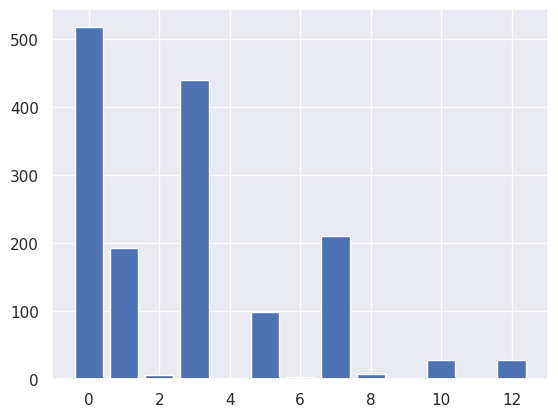

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.bar(*np.unique(test_preds.values.argmax(axis=-1), return_counts=True))

## Submission

In [55]:
submission = pd.read_csv(f"{data_dir}/source/SampleSubmission.csv")
display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
submission["Wheat"] = test_preds[0].values
submission["Mustard"] = test_preds[1].values
submission["Lentil"] = test_preds[2].values
submission["No Crop"] = test_preds[3].values
submission["Green pea"] = test_preds[4].values
submission["Sugarcane"] = test_preds[5].values
submission["Garlic"] = test_preds[6].values
submission["Gram"] = test_preds[7].values
submission["Maize"] = test_preds[8].values
submission["Coriander"] = test_preds[9].values
submission["Potato"] = test_preds[10].values
submission["Bersem"] = test_preds[11].values
submission["Rice"] = test_preds[12].values

display(submission.head())

,Field ID,Wheat,Mustard,Lentil,No Crop,Green pea,Sugarcane,Garlic,Maize,Gram,Coriander,Potato,Bersem,Rice
0,11,0.224952,0.275090,0.018238,0.057193,0.002665,0.419080,0.000238,0.000100,0.001153,0.000064,0.000207,0.000055,0.000965
1,13,0.659193,0.158937,0.010352,0.152291,0.002865,0.010583,0.001044,0.000796,0.000033,0.000108,0.000427,0.001243,0.002127
2,19,0.402565,0.263786,0.033619,0.080272,0.001090,0.213687,0.001194,0.000361,0.000021,0.003006,0.000097,0.000274,0.000028
3,21,0.092285,0.210774,0.020323,0.465516,0.001574,0.198402,0.001808,0.000921,0.000308,0.000073,0.003758,0.004072,0.000187
4,25,0.209006,0.051374,0.204729,0.531019,0.000130,0.002840,0.000278,0.000467,0.000002,0.000029,0.000004,0.000111,0.000010


In [57]:
submission.to_csv(f"{get_dir(output_dir, 'submissions')}/ensemble_catboost_lda.csv", index = False)

## References
- Papers
    - https://www.researchgate.net/publication/360681295_The_Evaluation_of_Spectral_Vegetation_Indexes_and_Redundancy_Reduction_on_the_Accuracy_of_Crop_Type_Detection
    - https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-12/issue-02/026019/Crop-classification-from-Sentinel-2-derived-vegetation-indices-using-ensemble/10.1117/1.JRS.12.026019.full
    - https://github.com/ArnolFokam/crop-type-detection-ICLR-2020/blob/master/solutions/youngtard/solution.ipynb

- Ideas & ressources
    - https://bigearth.net/#downloads
    - https://www.mdpi.com/2072-4292/13/23/4875
    - https://ai.facebook.com/blog/dino-paws-computer-vision-with-self-supervised-transformers-and-10x-more-efficient-training/